In [1]:
import sys
import pathlib
sys.path.append(str(pathlib.PurePath(pathlib.Path.cwd().parent)))

import os
import h5py
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import SALib as salib
from SALib.sample import sobol as salib_sample_sobol
from SALib.analyze import delta, dgsm, fast, ff, hdmr, morris, pawn, rbd_fast, sobol

import dimod
import dwave
import dwave.system
from dwave.system import DWaveSampler, EmbeddingComposite, FixedEmbeddingComposite
import dwave.inspector
import dwave_networkx as dnx
import minorminer
import embera

from src.particle_funcs import distance_matrix as distance_matrix
import src.leap_funcs.qubo.q_matrix as q_matrix

from src import leap_funcs as leap_funcs
from src.leap_funcs import embedding_quality

from src import h5py_funcs
from src.h5py_funcs import discoveries, init_custom_getstates, io, parameterstudy_using_info_file

Custom getstate functions for dwave.cloud.config.models.ClientConfig, dwave.cloud.client.qpu.Client, dwave.cloud.solver.StructuredSolver, dwave.system.samplers.dwave_sampler.DWaveSampler, dwave.system.composites.embedding.FixedEmbeddingComposite have been initialized.


[1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1.]


C:\Users\oahre\AppData\Local\Temp\ipykernel_23964\3430350851.py:15: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig_initial.show()


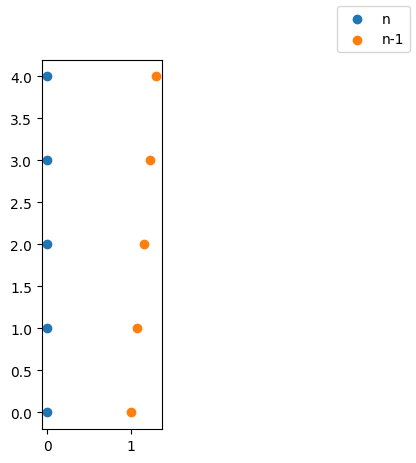

In [2]:
num_particles = 5

part_coords_n = np.zeros((num_particles,2))
part_coords_nm1 = np.zeros((num_particles,2))

for i in range(np.shape(part_coords_n)[0]):
    part_coords_n[i,:] = [0, i]
    part_coords_nm1[i,:] = [1.0*1+0.075*i, i]

fig_initial, axs_initial = plt.subplots(1,1)
axs_initial.scatter(part_coords_n[:,0], part_coords_n[:,1], label="n")
axs_initial.scatter(part_coords_nm1[:,0], part_coords_nm1[:,1], label="n-1")
axs_initial.set_aspect('equal')
fig_initial.legend()
fig_initial.show()

correct_sol = np.zeros(num_particles*num_particles)
for i in range(1, num_particles+1):
    correct_sol[(i-1)*num_particles + i -1] = 1.

print(correct_sol)

In [3]:
distances = distance_matrix.calc_phi_ij(part_coords_n, part_coords_nm1)
Q_dist_diag = q_matrix.q_dist_diag(distances)
Q_part = q_matrix.q_part(np.shape(distances)[0])
Q_pos = q_matrix.q_pos(np.shape(distances)[0])
Q_array = Q_dist_diag + Q_part + Q_pos
Q_dict = q_matrix.Q_convert_to_dict(Q_array)
#with np.printoptions(precision=3, linewidth=1000, threshold=1e6):
#    print(Q_array)

In [4]:
#problem = {
#    'num_vars': 2,
#    'names': ['num_reads', 'num_sweeps'],
#    'sets': np.array([[100,100], [1000,100], [2500,100], [5000,100], [100,1000], [1000,1000], [2500,1000], [5000,1000], [100,2500], [1000,2500], [2500,2500], [5000,2500]])
#}

problem_salib = {
    'num_vars': 3,
    'names': ['annealing_time', 'programming_thermalization', 'readout_thermalization'],
    #'bounds': [[0.5, 2000.0], [0.0, 10000.0], [0.0, 10000.0]]
    'bounds': [[0.5, 1000.0], [0.0, 1000.0], [0.0, 1000.0]]
}
samples_salib = salib.sample.sobol.sample(problem_salib, np.power(2,8), calc_second_order=True)

#print(problem['sets']),problem['sets'])
#print(problem['sets'][0]), problem['sets'][0])
print(type(samples_salib), samples_salib)
print((samples_salib[0]), samples_salib[0])
print((samples_salib[0][0]), samples_salib[0][0])

for i in range(np.shape(samples_salib)[0]):
    print(samples_salib[i])

<class 'numpy.ndarray'> [[692.46996336 186.07428297 521.40971273]
 [ 85.55703556 186.07428297 521.40971273]
 [692.46996336 445.05679607 521.40971273]
 ...
 [995.82948829 525.67785978 558.61920025]
 [995.82948829 903.95498369 253.70842312]
 [995.82948829 903.95498369 558.61920025]]
[692.46996336 186.07428297 521.40971273] [692.46996336 186.07428297 521.40971273]
692.4699633610435 692.4699633610435
[692.46996336 186.07428297 521.40971273]
[ 85.55703556 186.07428297 521.40971273]
[692.46996336 445.05679607 521.40971273]
[692.46996336 186.07428297 136.67077105]
[692.46996336 445.05679607 136.67077105]
[ 85.55703556 186.07428297 136.67077105]
[ 85.55703556 445.05679607 521.40971273]
[ 85.55703556 445.05679607 136.67077105]
[435.12523411 948.41557182  71.59030531]
[894.3835532  948.41557182  71.59030531]
[435.12523411 939.79117088  71.59030531]
[435.12523411 948.41557182 912.89931443]
[435.12523411 939.79117088 912.89931443]
[894.3835532  948.41557182 912.89931443]
[894.3835532  939.79117088

In [5]:
with open('../API_Token_Oliver_QCSE.txt') as file:
    token = file.readline().rstrip()
    architecture = file.readline().rstrip()

embedding_file_path = 'test_analyze_embedding'
embedding_file_name = 'analyzes_parts_{}_{}.h5'.format(5, '09')
embedding_file_name_path = os.path.join(embedding_file_path, embedding_file_name)
embedding_name = 'embedding'+'_em_wo_migration_layout'
read_embedding = h5py_funcs.io.read_embedding_from_hdf5_file(file_name_path=embedding_file_name_path, data_name=embedding_name)

sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
composite = FixedEmbeddingComposite(sampler, read_embedding)

access_time = 0.0

num_qubits = len(set(inner for outer in read_embedding.values() for inner in outer))
for param_set in samples_salib:
    _tmp = composite.child.solver.estimate_qpu_access_time(num_qubits=num_qubits, num_reads=1000, annealing_time=param_set[0], programming_thermalization=param_set[1], readout_thermalization=param_set[2])
    access_time += _tmp
    print(_tmp)
print(access_time)
print(access_time/1e6)
print('30 mins', 30*60)
print(len(samples_salib))

1346032.410659951
739119.4828605585
1346291.3931730508
961293.4689830363
961552.4514961363
354380.54118364386
739378.4653736585
354639.52369674377
639630.6152694233
1098888.9343572154
639621.9908684798
1480939.6243892915
1480930.999988348
1940197.9434770837
1098880.309956272
1940189.3190761402
1002260.2327448622
1248443.815399085
1002509.9220631019
876185.9270093337
876435.6163275734
1122369.5096635565
1248693.5047173246
1122619.1989817962
1225712.695958682
1132413.2500911437
1225291.4984995804
1428076.5632713519
1427655.3658122502
1334777.1174038134
1131992.052632042
1334355.9199447117
1245592.7381446888
802327.8942938269
1245409.2255063658
1154099.788159721
1153916.275521398
710834.9443088592
802144.3816555039
710651.4316705362
983597.9609416173
1333870.1619167186
983625.1747134448
1025684.2995659754
1025711.513337803
1375956.5005410768
1333897.375688546
1375983.7143129043
855497.4734314092
1429241.4048981227
856219.6631251209
989095.0252764233
989817.214970135
1562838.9567431367
142

In [6]:
emb_suffix = ['_em_wo_migration_layout']
file_suffix= ['09']
#file_suffix= ['01', '02', '03', '04', '05']

emb_suffix_id = 0
file_suffix_id = 0

#num_paramsets = 10 # will be turned to num_runs
#problem_dict = {'num_vars': 3,
#                'names': ['placeholder2', 'placeholde2'],
#                'bounds': [[10,20], [11,22]]
#                }
#parametersets_array = np.array([tuple((1,2)) for i in range(num_paramsets)])
#parametersets_array = np.array([[1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2], [1,2]])

problem_dict = problem_salib
parametersets_array = samples_salib


In [16]:
with open('../API_Token_Oliver_QCSE.txt') as file:
    token = file.readline().rstrip()
    architecture = file.readline().rstrip()

#for file_suffix_id in range(len(file_suffix)):
#    for emb_suffix_id in range(len(emb_suffix)):
#        print('file_suffix_id:', file_suffix_id, 'emb_suffix_id:', emb_suffix_id)
#        print('file_suffix:', file_suffix[file_suffix_id], 'emb_suffix:', emb_suffix[emb_suffix_id])

sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
sampler_graph = sampler.to_networkx_graph()

embedding_file_path = 'test_analyze_embedding'
embedding_file_name = 'analyzes_parts_{}_{}.h5'.format(num_particles, file_suffix[file_suffix_id])
embedding_file_name_path = os.path.join(embedding_file_path, embedding_file_name)

embedding_name = 'embedding'+emb_suffix[emb_suffix_id]
read_embedding = h5py_funcs.io.read_embedding_from_hdf5_file(file_name_path=embedding_file_name_path, data_name=embedding_name)

folder_path = 'test_params_annealer'
data_file_name = 'parameterstudy_data_{}_{}_{}_4.h5'.format(num_particles, emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
data_file_name_path = os.path.join(folder_path, data_file_name)
info_file_name = 'parameterstudy_info_{}_{}_{}_4.h5'.format(num_particles, emb_suffix[emb_suffix_id], file_suffix[file_suffix_id])
info_file_name_path = os.path.join(folder_path, info_file_name)
metadata_dict = {'num_particles': num_particles,
                 'embedding_file': embedding_file_name_path
}
kwargs_info_file = {'metadata_dict': metadata_dict,
                    'problem_dict': problem_dict,
                    'parametersets_array': parametersets_array,
                    'folder_path_name': folder_path,
                    'info_file_name': info_file_name}
h5py_funcs.parameterstudy_using_info_file.prepare_info_file(**kwargs_info_file)
read_parametersets = {}
with h5py.File(info_file_name_path, 'r') as f:
    read_parametersets['sets'] = f['/parametersets/study'].fields('sets')[()]
    read_parametersets['identifiers'] = f['/parametersets/study'].fields('identifiers')[()]
    read_parametersets['info'] = {key: value for key, value in f['/parametersets'].attrs.items()}
    read_parametersets['attrs'] = {}
    for _id in read_parametersets['identifiers']:
        read_parametersets['attrs'][_id] = {key: value for key, value in f['parametersets']['time_history'][_id].attrs.items()}
#print(read_parametersets)
#print(read_parametersets['sets']['num_reads'])
#print(read_parametersets['sets'].shape)
print('Number of parametersets:', len(read_parametersets['sets']))
print('number of identifiers:', len(read_parametersets['identifiers']))
if len(parametersets_array) == len(read_parametersets['identifiers']):
    num_runs = len(parametersets_array)
else:
    raise ValueError('Number of identifiers does not match number of parametersets ({} != {})'.format(len(parametersets_array), len(read_parametersets['identifiers'])))
failed_runs = {}
for i in range(516,num_runs):
    try:
        print('start run {} of {}'.format(i+1, num_runs))
        set_identifier = read_parametersets['identifiers'][i]
        if read_parametersets['attrs'][set_identifier]['ready']==True and read_parametersets['attrs'][set_identifier]['finished']==False:
            pass
        elif read_parametersets['attrs'][set_identifier]['ready']==True and read_parametersets['attrs'][set_identifier]['finished']==True:
            print('  run {} of {} already finished. Will be skipped'.format(i+1, num_runs))
            continue
        elif read_parametersets['attrs'][set_identifier]['ready']==False:
            raise ValueError('  run {} of {} not ready (attr. infofile for set_identifier{}). Will be skipped'.format(i+1, num_runs, set_identifier))
        sampler = DWaveSampler(token = token, architecture='pegasus', region='eu-central-1')
        tmp_not_needed_as_a_variable = sampler.adjacency # required for sampler having all data needed for __getstate__, no idea why this is necessary
        composite = FixedEmbeddingComposite(sampler, read_embedding)
        h5py_funcs.parameterstudy_using_info_file.update_timestamp_in_info_file(file_name_path=info_file_name_path, set_identifier=set_identifier, name='start')
        #kwargs = {key: read_parametersets['sets'][key][i][0] for key in read_parametersets['sets'].dtype.names} # ['sets'][key][i][0] : [0] is required because have shape (1,) 
        kwargs_annealer = {'label' : data_file_name+set_identifier.decode('utf-8'),
                            'annealing_time': parametersets_array[i][0], 
                            'num_reads': 1000, 
                            'answer_mode': 'raw', 
                            'programming_thermalization': parametersets_array[i][1], 
                            'readout_thermalization': parametersets_array[i][2],
                            }
        
        #print(kwargs)
        #sampleset={'sample_1': 'sample_1', 'sample_2': 'sample_2', 'info': {}}
        sampleset = composite.sample_qubo(Q_dict, **kwargs_annealer)
        print('  successfully finished sampling')
        print('  start writing data to file')
        dict_data = {'sampleset': sampleset.to_serializable(pack_samples=False), 'set_identifier': set_identifier}
        #dict_data = {'sampleset': sampleset, 'set_identifier': set_identifier}
        kwargs_write_sampleset = {'file_name_path': data_file_name_path,
                                   'dict_data': dict_data,
                                   'data_name': 'sampleset',
                                    #'name_suffix': set_identifier.decode('utf-8'), 
                                    'overwrite_data_in_file': False,
                                    'track_order': True}
        h5py_funcs.io.write_to_hdf5_file(**kwargs_write_sampleset)
        h5py_funcs.parameterstudy_using_info_file.update_timestamp_in_info_file(file_name_path=info_file_name_path, set_identifier=set_identifier, name='finish')
        print('  successfully finished writing data to file')
        del tmp_not_needed_as_a_variable
        del composite
        del sampler
        del sampleset
        del kwargs_write_sampleset
        del dict_data
        del kwargs_annealer
        del set_identifier
    except Exception as e: 
        #e='hi'
        print('  failed run {} of {}, check message for info, samples might still be vaild'.format(i+1, num_runs))
        failed_runs[f'{i}'] = {'set_identifier': set_identifier, 'Message': e}
        continue
print('number of failed runs: {}'.format(len(failed_runs)), ' Failed runs:', failed_runs)

Created new info-file parameterstudy_info_5__em_wo_migration_layout_09_4.h5 in folder test_params_annealer.
Number of parametersets: 2048
number of identifiers: 2048
start run 517 of 2048
  successfully finished sampling
  start writing data to file
  failed run 517 of 2048, check message for info, samples might still be vaild
start run 518 of 2048
  successfully finished sampling
  start writing data to file
  failed run 518 of 2048, check message for info, samples might still be vaild
start run 519 of 2048
  successfully finished sampling
  start writing data to file
  failed run 519 of 2048, check message for info, samples might still be vaild
start run 520 of 2048
  successfully finished sampling
  start writing data to file
  failed run 520 of 2048, check message for info, samples might still be vaild
start run 521 of 2048
  successfully finished sampling
  start writing data to file
  failed run 521 of 2048, check message for info, samples might still be vaild
start run 522 of 20

KeyboardInterrupt: 

In [15]:

del sampleset

In [17]:
failed_runs

{'516': {'set_identifier': b'zz_0487779494',
  'Message': dwave.cloud.exceptions.SolverFailureError('The problem cannot be submitted because its estimated QPU access time of 1149656 microseconds exceeds the maximum of 1000000 microseconds for Advantage_system5.4. To resolve this issue, see the topic at https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#keeping-within-the-runtime-limit.')},
 '517': {'set_identifier': b'zz_7763993002',
  'Message': dwave.cloud.exceptions.SolverFailureError('The problem cannot be submitted because its estimated QPU access time of 1091364 microseconds exceeds the maximum of 1000000 microseconds for Advantage_system5.4. To resolve this issue, see the topic at https://docs.dwavesys.com/docs/latest/c_qpu_timing.html#keeping-within-the-runtime-limit.')},
 '518': {'set_identifier': b'zz_5348831491',
  'Message': dwave.cloud.exceptions.SolverFailureError('The problem cannot be submitted because its estimated QPU access time of 1151340 microseconds exceeds t